Simulator: Intervening Objects
==============================

This script simulates `Imaging` of a strong lens where:

 - The lens galaxy's total mass distribution is an EllipticalBrokenPowerLaw.
 - The source galaxy's `LightProfile` is an `EllipticalSersic`.
 - There are a number of intervening objects whose light nearly obscures that of the strong lens.

This dataset is used in the preprocess script:

 `autolens_workspace/notebooks/preprocess/imaging/p8_scaled_dataset.ipynb`

To illustrate how to subtract and remove the light of intervening objects in real strong lensing data, so that it does
not impact the lens model.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


The `dataset_type` describes the type of data being simulated (in this case, `Imaging` data) and `dataset_name`
gives it a descriptive name. They define the folder the dataset is output to on your hard-disk:

 - The image will be output to `/autolens_workspace/dataset/dataset_type/dataset_label/dataset_name/image.fits`.
 - The noise-map will be output to `/autolens_workspace/dataset/dataset_type/dataset_label/dataset_name/noise_map.fits`.
 - The psf will be output to `/autolens_workspace/dataset/dataset_type/dataset_label/dataset_name/psf.fits`.

In [2]:
dataset_type = "imaging"
dataset_label = "no_lens_light"
dataset_name = "mass_sie__source_sersic__intervening_objects"

The path where the dataset will be output, which in this case is:
`/autolens_workspace/dataset/imaging/no_lens_light/mass_sie__source_sersic__intervening_objects/`

In [3]:
dataset_path = path.join("dataset", dataset_type, dataset_label, dataset_name)

For simulating an image of a strong lens, we recommend using a Grid2DIterate object. This represents a grid of (y,x) 
coordinates like an ordinary Grid2D, but when the light-profile`s image is evaluated below (using the Tracer) the 
sub-size of the grid is iteratively increased (in steps of 2, 4, 8, 16, 24) until the input fractional accuracy of 
99.99% is met.

This ensures that the divergent and bright central regions of the source galaxy are fully resolved when determining the
total flux emitted within a pixel.

In [4]:
grid = al.Grid2DIterate.uniform(
    shape_native=(100, 100),
    pixel_scales=0.1,
    fractional_accuracy=0.9999,
    sub_steps=[2, 4, 8, 16, 24],
)

Simulate a simple Gaussian PSF for the image.

In [5]:
psf = al.Kernel2D.from_gaussian(
    shape_native=(11, 11), sigma=0.1, pixel_scales=grid.pixel_scales
)

To simulate the `Imaging` dataset we first create a simulator, which defines the exposure time, background sky,
noise levels and psf of the dataset that is simulated.

In [6]:
simulator = al.SimulatorImaging(
    exposure_time=300.0, psf=psf, background_sky_level=0.1, add_poisson_noise=True
)

The lens galaxy includes some intervening objects, which must be masked / have their noise-map increased in
preprocessing to ensure they do not impact the fit.

For lens modeling, defining ellipticity in terms of the `elliptical_comps` improves the model-fitting procedure.

However, for simulating a strong lens you may find it more intuitive to define the elliptical geometry using the 
axis-ratio of the profile (axis_ratio = semi-major axis / semi-minor axis = b/a) and position angle phi, where phi is
in degrees and defined counter clockwise from the positive x-axis.

We can use the **PyAutoLens** `convert` module to determine the elliptical components from the axis-ratio and phi.

In [7]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    intervene_0=al.lp.SphericalExponential(
        centre=(1.0, 3.5), intensity=0.8, effective_radius=0.5
    ),
    intervene_1=al.lp.SphericalExponential(
        centre=(-2.0, -3.5), intensity=0.5, effective_radius=0.8
    ),
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, phi=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.0, 0.05)),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0.1, 0.1),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, phi=60.0),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

Use these galaxies to setup a tracer, which will generate the image for the simulated `Imaging` dataset.

In [8]:
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

Lets look at the tracer`s image, this is the image we'll be simulating.

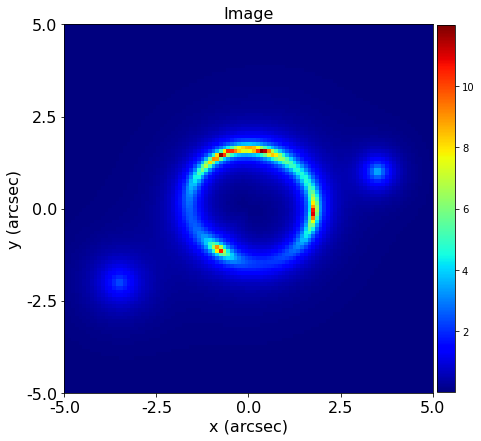

In [9]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures(image=True)

We can now pass this simulator a tracer, which creates the ray-traced image plotted above and simulates it as an
imaging dataset.

In [10]:
imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

Lets plot the simulated `Imaging` dataset before we output it to fits.

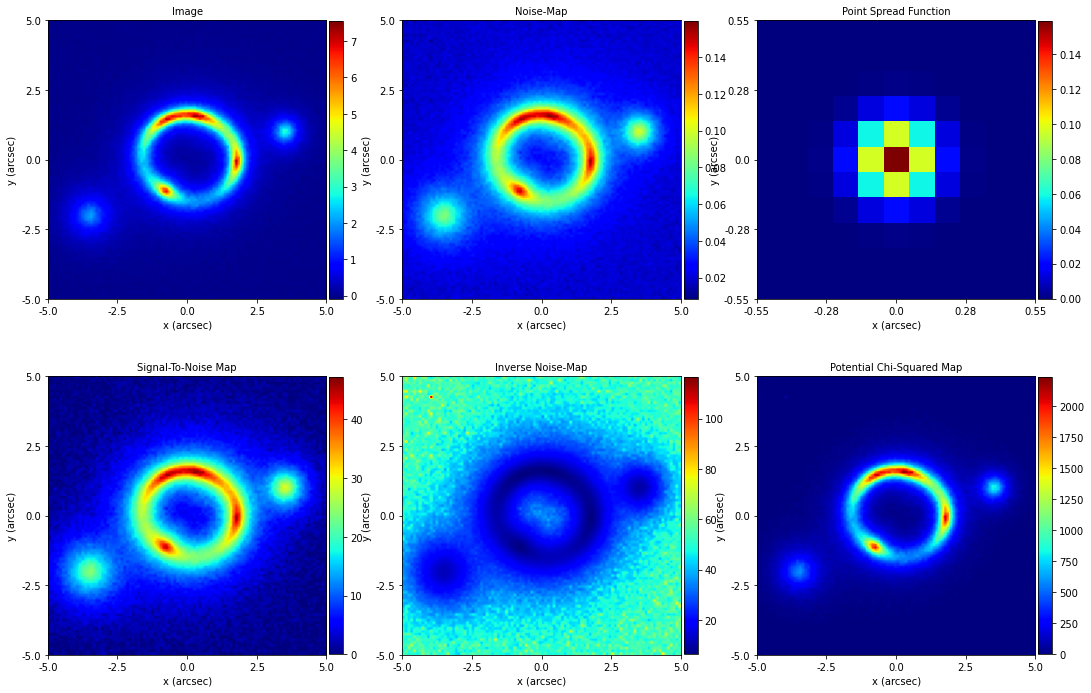

In [11]:
imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

Output the simulated dataset to the dataset path as .fits files.

In [12]:
imaging.output_to_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    overwrite=True,
)

Output a subplot of the simulated dataset, the image and a subplot of the `Tracer`'s quantities to the dataset path 
as .png files.

In [13]:
mat_plot_2d = aplt.MatPlot2D(output=aplt.Output(path=dataset_path, format="png"))

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, mat_plot_2d=mat_plot_2d)
imaging_plotter.subplot_imaging()
imaging_plotter.figures(image=True)

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid, mat_plot_2d=mat_plot_2d)
tracer_plotter.subplot_tracer()

Pickle the `Tracer` in the dataset folder, ensuring the true `Tracer` is safely stored and available if we need to 
check how the dataset was simulated in the future. 

This will also be accessible via the `Aggregator` if a model-fit is performed using the dataset.

In [14]:
tracer.save(file_path=dataset_path, filename="true_tracer")

The dataset can be viewed in the folder `autolens_workspace/imaging/no_lens_light/mass_sie__source_sersic__intervening_objects`.